In [1]:
import glob
import os
from PIL import Image
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.ndimage import measurements,morphology
from skimage import filters
from skimage import measure
from skimage import segmentation
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
Image.MAX_IMAGE_PIXELS = 1000000000
path = os.getcwd()+'/data/210625_AM011_IHC_analysis'
data_list = sorted(glob.glob(path + '/*_whole_slide_merge.tif'))
output_dir = path + '/cropped/'
os.makedirs(output_dir, exist_ok=True)

count=0

data_list

['/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/01_whole_slide_merge.tif',
 '/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/02_whole_slide_merge.tif',
 '/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/03_whole_slide_merge.tif',
 '/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/04_whole_slide_merge.tif',
 '/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/05_whole_slide_merge.tif',
 '/home/ysaito/Synology/section_isolater/data/210625_AM011_IHC_analysis/06_whole_slide_merge.tif']

CPU times: user 11min 35s, sys: 3min 7s, total: 14min 43s
Wall time: 16min 9s


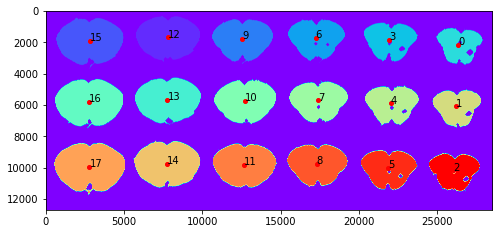

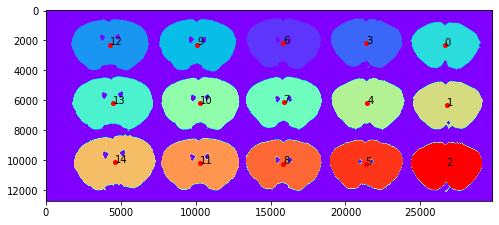

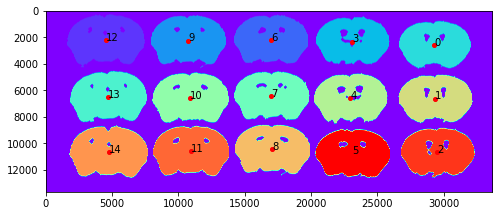

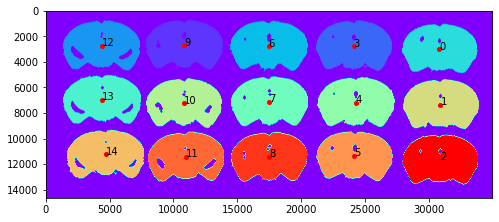

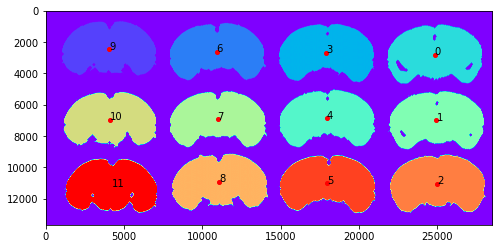

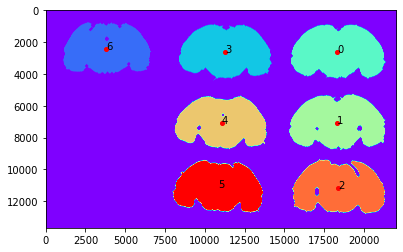

In [3]:
%%time
for l in range(len(data_list)):
    data_path=data_list[l]

    img = np.array(Image.open(data_path))
    counter_ch = img[:,:,2]
    #plt.imshow(counter_ch, cmap='gray');

    # 二値化
    val = filters.threshold_otsu(counter_ch)
    mask = counter_ch > val

    # 小領域を塗りつぶす
    open_img = ndimage.binary_opening(mask)
    close_img = ndimage.binary_closing(open_img,  iterations=100)

    # ラベル付け
    label_im, nb_labels = ndimage.label(close_img)

    #ラベルされたごみを除去する
    sizes = ndimage.sum(mask, label_im, range(nb_labels+1))
    mask_size = sizes < 100000
    remove_pixel = mask_size[label_im]
    label_im[remove_pixel] = 0
    labels = np.unique(label_im)
    label_clean = np.searchsorted(labels, label_im)
    # 背景を削除
    label_clean = label_clean.astype(float)

    #各切片の重心を求める -> sort
    point = measurements.center_of_mass(close_img, label_clean, range(1, len(labels) + 1))
    xlen, ylen = len(img[0]), len(img)
    gs_x = np.array(point)
    gs = gs_x[:,0]*(5000/10000) + (xlen -gs_x[:,1])*(12000/10000)
    gs = gs[~np.isnan(gs)]
    order = np.argsort(gs)
    fig = plt.figure(figsize=(8, 4)) 
    plt.plot(np.array(point)[:,1],np.array(point)[:,0],'ro',ms=4)
    plt.imshow(label_clean, cmap='rainbow')
    for i, n in enumerate(order):
        plt.text(point[n][1], point[n][0], str(i))

    counters = measure.find_contours(label_clean, 0.5)
    counters_clean=[]
    for i in range(len(counters)):
        if len(counters[i]) > 10000:
            a=counters[i].tolist()
            counters_clean.append(a)

    buf = 50
    for m,n in enumerate(order):
        rngx = (int(np.min(np.array(counters_clean[n])[:,1])) - buf, int(np.max(np.array(counters_clean[n])[:,1])) + buf)
        rngy = (int(np.min(np.array(counters_clean[n])[:,0])) - buf, int(np.max(np.array(counters_clean[n])[:,0])) + buf)
        cropped = np.zeros((max(rngy) - min(rngy),max(rngx) - min(rngx),3), dtype = "uint8")
        for i in range(3):
            cropped[:,:,i] = np.where(close_img[rngy[0]:rngy[1],rngx[0]:rngx[1]]==True, img[rngy[0]:rngy[1],rngx[0]:rngx[1],i],0)
        cropped_img = Image.fromarray(cropped)
        cropped_img.save(output_dir + "section{:03}.tif".format(m+count), quality=100)
    count += len(order)